# Anwendung FLAIR-INC Model

## Vorbereitung Modell

@inproceedings{ign-flair,
      title={FLAIR: a Country-Scale Land Cover Semantic Segmentation Dataset From Multi-Source Optical Imagery},
      author={Anatol Garioud and Nicolas Gonthier and Loic Landrieu and Apolline De Wit and Marion Valette and Marc Poupée and Sébastien Giordano and Boris Wattrelos},
      year={2023},
      booktitle={Advances in Neural Information Processing Systems (NeurIPS) 2023},
      doi={https://doi.org/10.48550/arXiv.2310.13336},

}


es wird nun diese MOdell hier verwendet:
https://huggingface.co/IGNF/FLAIR-INC_rgbi_15cl_resnet34-unet

Die Anleitung dazu gibt es in gitHub:
https://github.com/IGNF/FLAIR-1

In [ ]:
#Klone das FLAIR-1 Repository und installiere die erforderlichen Abhängigkeiten.

!git clone https://github.com/IGNF/FLAIR-1.git
%cd FLAIR-1
!pip install -e .

fatal: destination path 'FLAIR-1' already exists and is not an empty directory.
/content/FLAIR-1
Obtaining file:///content/FLAIR-1
  Preparing metadata (setup.py) ... done
  Attempting uninstall: flair
    Found existing installation: flair 0.2.0
    Uninstalling flair-0.2.0:
      Successfully uninstalled flair-0.2.0
  Running setup.py develop for flair


# Format konvertieren für CVAT

Nachdem die Klassen nicht passen für mein MOdell muss ich das jetzt noch manuell detaillierter Labeln


### Versuch 1 mit PNG zu arbeiten

Hier ist der Code, um deine Vorhersagedaten (z.B. aus einer TIFF-Datei oder einem NumPy-Array) in ein PNG-Bild umzuwandeln, das dann in CVAT als Maskenbild verwendet werden kann.

In [ ]:
!pip install imagecodecs  # Install the necessary package

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 11.5 MB/s eta 0:00:00


In [ ]:
from imagecodecs import LZW
print("LZW Codec verfügbar:", LZW.available)

LZW Codec verfügbar: True


*Why Convert to PNG First?*

Converting the TIFF image into a PNG format could simplify the process because PNG is a more widely used format for processing in tools like OpenCV. CVAT can handle PNG segmentation masks directly, and PNG is often easier to work with due to better software support.
TIFF is a more complex format that includes metadata and may use compression schemes that are harder to process with some libraries, whereas PNG is simpler and more compatible with annotation tools.

In [ ]:
from PIL import Image
import numpy as np
import tifffile

# Lade das TIFF-Bild
tiff_image = tifffile.imread('/content/drive/MyDrive/LabelingModel/output/result_raster_15cl.tif')

# Konvertiere die TIFF-Daten in das PNG-Format
png_image = Image.fromarray(np.uint8(tiff_image))
png_image.save('/content/drive/MyDrive/LabelingModel/output/result_raster_15cl.png')


# Zeige das Bild an
plt.imshow(png_image)
plt.axis('off')
plt.show()


NameError: name 'plt' is not defined

In [ ]:
import numpy as np
import cv2
from lxml import etree
from osgeo import gdal

# Liste der Klassenlabels, die du während des Trainings verwendet hast
class_labels = [
    'building', 'pervious surface', 'impervious surface', 'bare soil', 'water',
    'coniferous', 'deciduous', 'brushwood', 'vineyard', 'herbaceous',
    'agricultural land', 'plowed land', 'swimming pool', 'snow', 'greenhouse'
]

def create_pascal_voc_annotation(original_tiff_path, segmentation_tiff_path, output_xml_path):
    # Lade das Original-TIFF-Bild
    original_tiff = gdal.Open(original_tiff_path)

    # Lade das Segmentierungs-TIFF-Bild
    segmentation_tiff = gdal.Open(segmentation_tiff_path)
    mask_array = segmentation_tiff.ReadAsArray()

    # Normalisiere die Maske (wenn notwendig)
    mask_array = (mask_array * 255 / np.max(mask_array)).astype(np.uint8)

    # Finde die Konturen (Polygone) in der Maske
    contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Überprüfe, ob Konturen gefunden wurden
    if len(contours) == 0:
        print("Keine Konturen gefunden.")
        return

    # Erstellt das Root-Element für das Pascal VOC XML
    annotation = etree.Element("annotation")

    for contour in contours:
        if len(contour) > 0:
            # Finde den Klassenwert des ersten Punktes der Kontur
            x, y = contour[0][0]
            class_value = mask_array[y, x]  # Der Pixelwert, der der Klasse entspricht
            class_name = class_labels[class_value] if class_value < len(class_labels) else "unknown_class"

            # Füge das Objekt und den Klassennamen hinzu
            object_tag = etree.SubElement(annotation, "object")
            name = etree.SubElement(object_tag, "name")
            name.text = class_name  # Verwende die Klassenbezeichnung

            # Erstelle das Polygon mit den Konturpunkten
            polygon_tag = etree.SubElement(object_tag, "polygon")
            for point in contour:
                x, y = point[0]
                pt = etree.SubElement(polygon_tag, "pt")
                x_tag = etree.SubElement(pt, "x")
                y_tag = etree.SubElement(pt, "y")
                x_tag.text = str(x)
                y_tag.text = str(y)

    # Speichere die XML-Datei
    with open(output_xml_path, 'wb') as f:
        f.write(etree.tostring(annotation, pretty_print=True))

# Beispiel-Aufruf
create_pascal_voc_annotation(
    "/content/drive/MyDrive/Rasterdateien_GemeindeZürich/Parzelle_AF2399_2207.tif",  # Pfad zum Original-TIFF
    "/content/drive/MyDrive/LabelingModel/output/result_raster_15cl.tif",  # Pfad zur Segmentierungs-TIFF
    "/content/drive/MyDrive/LabelingModel/output/output.xml"  # Pfad, wo die XML gespeichert wird
)



klappt alles nicht, Idee ist jetzt über Docker das model hereinzuladen

Anleitung um als Nächstes das AUto Annotation Model in CVAT mit localhost zu öffnen:
https://docs.cvat.ai/docs/manual/advanced/automatic-annotation/#:~:text=Automatic%20annotation%20in%20CVAT%20is,from%20Hugging%20Face%20and%20Roboflow.


### Versuch 2: PASCAL VOC FORMAT

In [ ]:
import cv2
import os
import numpy as np
from lxml import etree
from PIL import Image

# List of class names in your dataset (adjust as needed for your case)
CLASSES = ['building', 'pervious_surface', 'impervious_surface', 'bare_soil', 'water',
           'coniferous', 'deciduous', 'brushwood', 'vineyard', 'herbaceous',
           'agricultural_land', 'plowed_land', 'swimming_pool', 'snow', 'greenhouse']

def create_pascal_voc_xml(output_path, image_name, image_size, annotations):
    """Creates a Pascal VOC XML file."""
    annotation = etree.Element("annotation")

    folder = etree.SubElement(annotation, "folder")
    folder.text = "VOC_dataset"

    filename = etree.SubElement(annotation, "filename")
    filename.text = image_name

    size = etree.SubElement(annotation, "size")
    width = etree.SubElement(size, "width")
    width.text = str(image_size[1])
    height = etree.SubElement(size, "height")
    height.text = str(image_size[0])
    depth = etree.SubElement(size, "depth")
    depth.text = "1"  # For grayscale mask

    for label, polygons in annotations.items():
        for polygon in polygons:
            obj = etree.SubElement(annotation, "object")
            name = etree.SubElement(obj, "name")
            name.text = CLASSES[label]

            bndbox = etree.SubElement(obj, "bndbox")
            xmin = etree.SubElement(bndbox, "xmin")
            ymin = etree.SubElement(bndbox, "ymin")
            xmax = etree.SubElement(bndbox, "xmax")
            ymax = etree.SubElement(bndbox, "ymax")

            # Use OpenCV boundingRect to get bounding box of polygon
            x, y, w, h = cv2.boundingRect(np.array(polygon))
            xmin.text = str(x)
            ymin.text = str(y)
            xmax.text = str(x + w)
            ymax.text = str(y + h)

    tree = etree.ElementTree(annotation)
    tree.write(output_path, pretty_print=True, xml_declaration=True, encoding="utf-8")

def process_segmentation_to_pascal_voc(tiff_image_path, output_folder, image_name):
    """Processes segmentation mask into Pascal VOC XML."""
    # Load the TIFF segmentation mask
    tiff_image = cv2.imread(tiff_image_path, cv2.IMREAD_GRAYSCALE)

    annotations = {}

    # Loop through each class ID
    for class_id in range(1, len(CLASSES)):  # Skip background (ID=0)
        mask = (tiff_image == class_id).astype(np.uint8)

        # Find contours for this class
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if class_id not in annotations:
            annotations[class_id] = []

        # Add polygons (contours) to annotations
        for contour in contours:
            if len(contour) > 2:  # Ensure valid polygons
                annotations[class_id].append(contour)

    # Generate Pascal VOC XML file for the image
    image_size = tiff_image.shape  # Get size of the image
    output_path = os.path.join(output_folder, image_name.replace(".tif", ".xml"))
    create_pascal_voc_xml(output_path, image_name, image_size, annotations)

# Specify paths and filenames
tiff_image_path = "/content/drive/MyDrive/LabelingModel/output/result_raster_15cl.tif"
output_folder = "/content/drive/MyDrive/LabelingModel/output/annotations"
image_name = "result_raster_15cl.tif"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Convert the segmentation mask to Pascal VOC XML
process_segmentation_to_pascal_voc(tiff_image_path, output_folder, image_name)



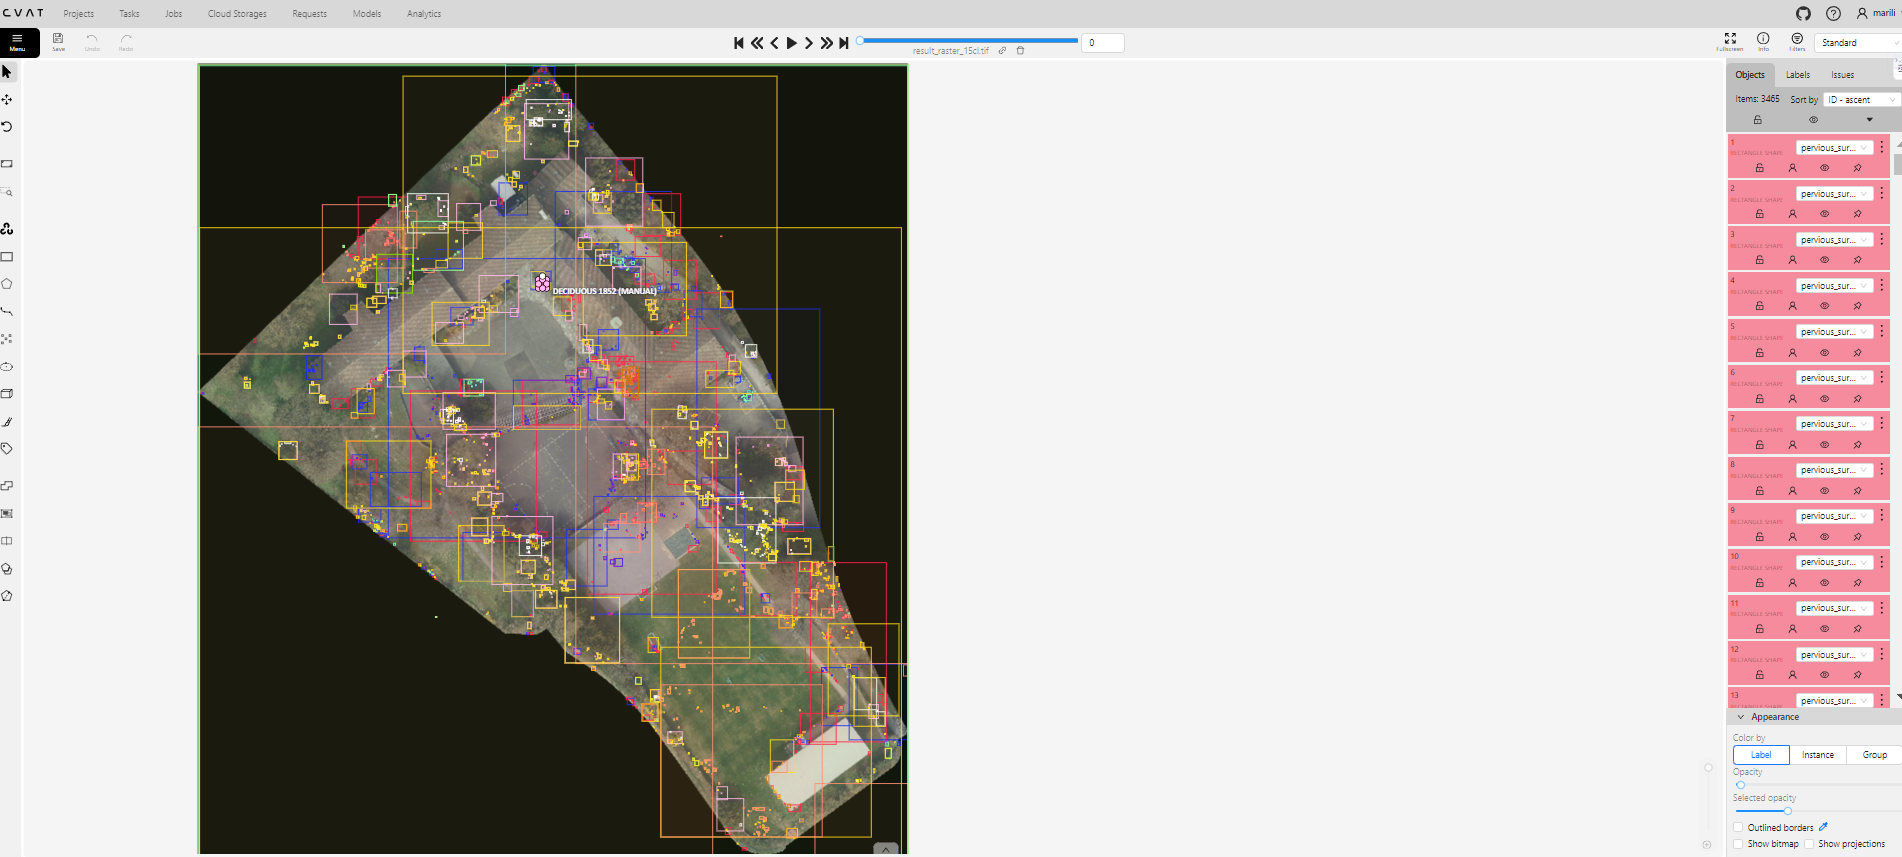

ergebnis in CVAT mit der Pascal datei. also es funktionert, aber das PASCAL Format gibt nur Bounding Boxes aus und keine Polygone

---



## Versuch 3: COCO - Format

In [ ]:
import os
import json
import cv2
import numpy as np
from pycocotools import mask
from PIL import Image

# Liste der Klassen (anpassen an deinen Datensatz)
CLASSES = ['building', 'pervious_surface', 'impervious_surface', 'bare_soil', 'water',
           'coniferous', 'deciduous', 'brushwood', 'vineyard', 'herbaceous',
           'agricultural_land', 'plowed_land', 'swimming_pool', 'snow', 'greenhouse']

def create_coco_annotations(tiff_image_path, output_json_path, image_name):
    """Konvertiert die Segmentierungsmaske in das COCO-Format."""

    # Lade das TIFF-Bild (Segmentierungsmaske)
    tiff_image = cv2.imread(tiff_image_path, cv2.IMREAD_GRAYSCALE)

    # Lege die COCO JSON-Struktur an
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Füge die Kategorien hinzu
    for idx, class_name in enumerate(CLASSES, 1):
        category = {
            "id": idx,
            "name": class_name,
            "supercategory": "none"
        }
        coco_output['categories'].append(category)

    # Bildinformationen hinzufügen
    height, width = tiff_image.shape
    image_info = {
        "id": 1,
        "file_name": image_name,
        "height": height,
        "width": width
    }
    coco_output['images'].append(image_info)

    annotation_id = 1
    # Verarbeite die Segmentierungsmaske zu Polygonen für jede Klasse
    for class_id in range(1, len(CLASSES)):  # Klasse 0 überspringen (Hintergrund)
        mask_class = (tiff_image == class_id).astype(np.uint8)

        # Finde Konturen für die Klasse
        contours, _ = cv2.findContours(mask_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) >= 3:  # Nur gültige Polygone
                segmentation = contour.flatten().tolist()
                x, y, w, h = cv2.boundingRect(contour)

                annotation = {
                    "id": annotation_id,
                    "image_id": 1,
                    "category_id": class_id,
                    "segmentation": [segmentation],
                    "area": cv2.contourArea(contour),
                    "bbox": [x, y, w, h],
                    "iscrowd": 0
                }
                coco_output['annotations'].append(annotation)
                annotation_id += 1

    # Speichere die Annotationsdatei als JSON
    with open(output_json_path, 'w') as f:
        json.dump(coco_output, f, indent=4)

# Pfade und Dateinamen
tiff_image_path = "/content/drive/MyDrive/LabelingModel/output/result_Parzelle_AF2399_2207.tif"
output_json_path = "/content/drive/MyDrive/LabelingModel/output/annotations_coco_Parzelle_AF2399_2207.json"
image_name = "result_Parzelle_AF2399_2207.tif"

# COCO-Anmerkungen erstellen
create_coco_annotations(tiff_image_path, output_json_path, image_name)


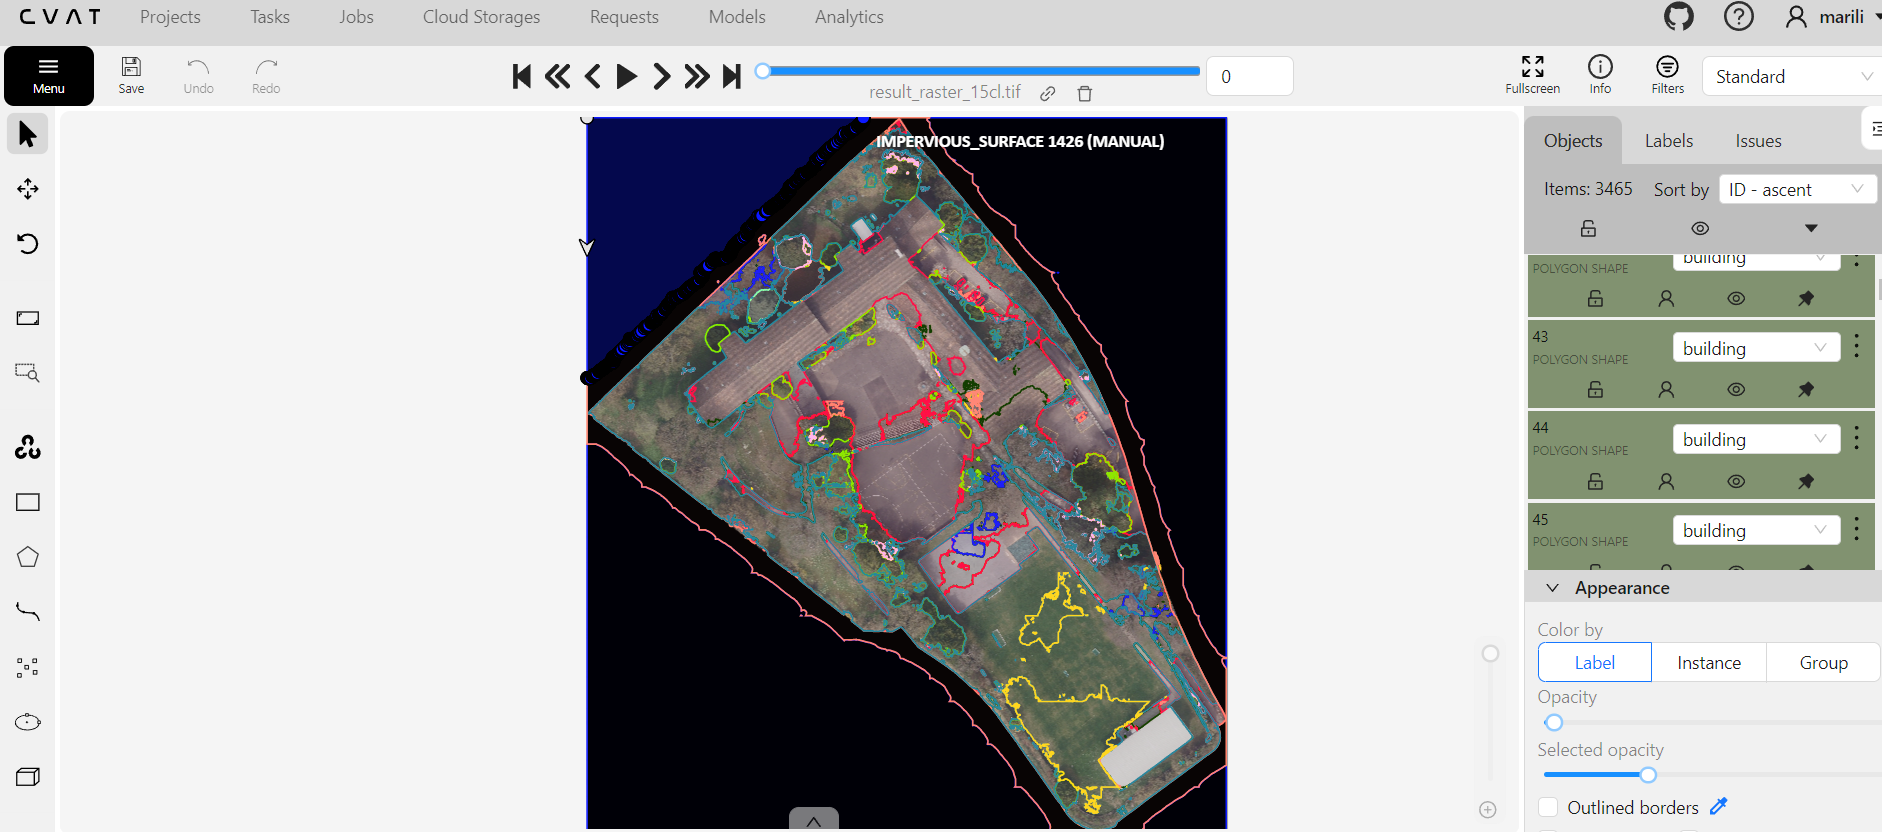

## Versuch 3.1: COCO-Format mit Labeling direkt auf BFF FLächentypen

d

das hier war der code, wo funktioniert hat!!! ⏰

In [ ]:
import os
import json
import cv2
import numpy as np
from pycocotools import mask
from PIL import Image

# Updated list of BFF categories
BFF_CLASSES = [
    'Gebäude',
    'Teilversiegelte Belagsfläche',
    'Versiegelte Belagsflächen',
    'Blaue Fläche',
    'Vegetationsfläche',
    'Vegetationsfläche mit Bodenanschluss'
]

# Mapping of original FLAIR class IDs to BFF categories
# Based on your provided mapping table
FLAIR_TO_BFF_MAPPING = {
    1: 1,   # Gebäude -> Gebäude
    2: 2,   # Durchlässige Oberfläche -> Teilversiegelte Belagsfläche
    3: 3,   # Undurchlässige Oberfläche -> Versiegelte Belagsflächen
    13: 3,  # Schwimmbad -> Versiegelte Belagsflächen
    18: 1,  # Gewächshaus -> Gebäude
    4: 2,   # Unbedeckter Boden -> Teilversiegelte Belagsfläche
    5: 4,   # Wasser -> Blaue Fläche
    14: 5,  # Schnee -> No BFF equivalent, skip
    6: 5,   # Nadelbäume -> Vegetationsfläche
    7: 5,   # Laubbäume -> Vegetationsfläche
    8: 5,   # Gestrüpp -> Vegetationsfläche
    15: 6,  # Kahlschlag -> Vegetationsfläche mit Bodenanschluss
    16: 6,  # Homogene Vegetation -> Vegetationsfläche mit Bodenanschluss
    17: 6,  # Gemischte Vegetation -> Vegetationsfläche mit Bodenanschluss
    9: 6,   # Weinberge -> Vegetationsfläche mit Bodenanschluss
    11: 6,  # Landwirtschaftliche Fläche -> Vegetationsfläche mit Bodenanschluss
    12: 6,  # Gepflügtes Land -> Vegetationsfläche mit Bodenanschluss
    10: 5   # Krautige Vegetation -> Vegetationsfläche
}

def create_coco_annotations(tiff_image_path, output_json_path, image_name):
    """Converts the segmentation mask into COCO format with merged labels."""

    # Load the TIFF image (segmentation mask)
    tiff_image = cv2.imread(tiff_image_path, cv2.IMREAD_GRAYSCALE)

    # Initialize the COCO JSON structure
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Add categories with BFF class names
    for idx, class_name in enumerate(BFF_CLASSES, 1):
        category = {
            "id": idx,
            "name": class_name,
            "supercategory": "none"
        }
        coco_output['categories'].append(category)

    # Image information
    height, width = tiff_image.shape
    image_info = {
        "id": 1,
        "file_name": image_name,
        "height": height,
        "width": width
    }
    coco_output['images'].append(image_info)

    annotation_id = 1
    # Process the segmentation mask and map FLAIR classes to BFF classes
    for original_class_id, bff_class_id in FLAIR_TO_BFF_MAPPING.items():
        if bff_class_id is None:
            continue  # Skip classes with no BFF equivalent

        # Create a binary mask for the current FLAIR class
        mask_class = (tiff_image == original_class_id).astype(np.uint8)

        # Find contours for the BFF class
        contours, _ = cv2.findContours(mask_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) >= 3:  # Only valid polygons
                segmentation = contour.flatten().tolist()
                x, y, w, h = cv2.boundingRect(contour)

                annotation = {
                    "id": annotation_id,
                    "image_id": 1,
                    "category_id": bff_class_id,
                    "segmentation": [segmentation],
                    "area": cv2.contourArea(contour),
                    "bbox": [x, y, w, h],
                    "iscrowd": 0
                }
                coco_output['annotations'].append(annotation)
                annotation_id += 1

    # Save the annotations to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_output, f, indent=4)

# Paths and file names
tiff_image_path = "/content/drive/MyDrive/LabelingModel/output/result_Parzelle_WI3878_2609.tif"
output_json_path = "/content/drive/MyDrive/LabelingModel/output/annotations_coco_Parzelle_WI3878_2609.json"
image_name = "Parzelle_WI3878_2609.tif"

# Create COCO annotations with merged labels
create_coco_annotations(tiff_image_path, output_json_path, image_name)


## nun für alle Tiffs die ANnotations COCO FOrmat erstellen

das Problem ist, dass die JSON aktuell jeweils den Task Namen in CVAT sucht für jede Annotation udn darum nicht zuweisen kann, da es nur einen Task "BioValues-Annotation" gibt, der alle Bilder enthält. Nun über die Frame-ID, also jedes Bild wird die Annotationsdatei zugewiesen


CVAT erwartet normalerweise, dass jede Anmerkung in der COCO-JSON-Datei mit einem eindeutigen Element verknüpft ist, das frame_idjedem Bild in der Aufgabe entspricht. Da Sie alle Bilder in einer einzigen Aufgabe zusammengefasst haben, hat CVAT wahrscheinlich Schwierigkeiten, jede Anmerkung einem bestimmten Frame innerhalb dieser Aufgabe zuzuordnen.

Um dies zu beheben, müssen Sie Folgendes sicherstellen:

Frame-IDs werden korrekt zugewiesen : CVAT erwartet, dass jedes Bild in der JSON-Datei eine hat frame_id, die der Reihenfolge entspricht, in der die Bilder in der Aufgabe hochgeladen wurden. Normalerweise hat das erste hochgeladene Bild eine frame_id = 0, das nächste eine frame_id = 1und so weiter.

Ändern Sie JSON, um Frame-IDs zu verwenden : Aktualisieren Sie Ihr JSON, sodass die Anmerkung jedes Bildes auf den richtigen Namen verweist frame_idund nicht nur auf den Dateinamen.

In [ ]:
import os
import json
import cv2
import numpy as np

# BFF-Klassenliste
BFF_CLASSES = [
    'Gebäude',
    'Teilversiegelte Belagsfläche',
    'Versiegelte Belagsflächen',
    'Blaue Fläche',
    'Vegetationsfläche',
    'Vegetationsfläche mit Bodenanschluss'
]

# Mapping der FLAIR-Klassen zu BFF-Klassen
FLAIR_TO_BFF_MAPPING = {
    1: 1,   # Gebäude -> Gebäude
    2: 2,   # Durchlässige Oberfläche -> Teilversiegelte Belagsfläche
    3: 3,   # Undurchlässige Oberfläche -> Versiegelte Belagsflächen
    13: 3,  # Schwimmbad -> Versiegelte Belagsflächen
    18: 1,  # Gewächshaus -> Gebäude
    4: 2,   # Unbedeckter Boden -> Teilversiegelte Belagsfläche
    5: 4,   # Wasser -> Blaue Fläche
    14: None,  # Schnee -> Keine Zuordnung
    6: 5,   # Nadelbäume -> Vegetationsfläche
    7: 5,   # Laubbäume -> Vegetationsfläche
    8: 5,   # Gestrüpp -> Vegetationsfläche
    15: 6,  # Kahlschlag -> Vegetationsfläche mit Bodenanschluss
    16: 6,  # Homogene Vegetation -> Vegetationsfläche mit Bodenanschluss
    17: 6,  # Gemischte Vegetation -> Vegetationsfläche mit Bodenanschluss
    9: 6,   # Weinberge -> Vegetationsfläche mit Bodenanschluss
    11: 6,  # Landwirtschaftliche Fläche -> Vegetationsfläche mit Bodenanschluss
    12: 6,  # Gepflügtes Land -> Vegetationsfläche mit Bodenanschluss
    10: 5   # Krautige Vegetation -> Vegetationsfläche
}

# Kombinierte COCO-Datei initialisieren
combined_coco_output = {
    "images": [],
    "annotations": [],
    "categories": []
}

# Kategorien hinzufügen
for idx, class_name in enumerate(BFF_CLASSES, 1):
    combined_coco_output['categories'].append({"id": idx, "name": class_name, "supercategory": "none"})

# Verzeichnispfade
input_folder = "/content/drive/MyDrive/LabelingModel/output/"
output_json_path = "/content/drive/MyDrive/LabelingModel/annotations/BioValues-Annotation_combined.json"

# Sicherstellen, dass das Output-Verzeichnis existiert
os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

# Bild- und Annotationszähler
annotation_id_counter = 1

# Alphabetische Liste der Dateien zum Festlegen der frame_id
file_list = sorted([f for f in os.listdir(input_folder) if f.endswith(".tif")])

# Durchlaufen der alphabetisch sortierten Dateien und frame_id zuweisen
for frame_id, filename in enumerate(file_list):
    tiff_image_path = os.path.join(input_folder, filename)
    image_name = filename

    # TIFF-Bild laden
    tiff_image = cv2.imread(tiff_image_path, cv2.IMREAD_GRAYSCALE)
    if tiff_image is None:
        print(f"Fehler beim Laden des Bildes {filename}, überspringe.")
        continue

    # Bildinformationen hinzufügen mit frame_id
    height, width = tiff_image.shape
    image_info = {
        "id": frame_id + 1,  # Alphabetische Reihenfolge der IDs
        "file_name": image_name,
        "height": height,
        "width": width
    }
    combined_coco_output['images'].append(image_info)

    # Annotations für das Bild erstellen
    for original_class_id, bff_class_id in FLAIR_TO_BFF_MAPPING.items():
        if bff_class_id is None:
            continue  # Überspringen, falls keine Zuordnung zu BFF

        # Maske für die aktuelle Klasse erstellen
        mask_class = (tiff_image == original_class_id).astype(np.uint8)

        # Konturen für die Klasse finden
        contours, _ = cv2.findContours(mask_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) >= 3:  # Nur gültige Polygone
                segmentation = contour.flatten().tolist()
                x, y, w, h = cv2.boundingRect(contour)

                annotation = {
                    "id": annotation_id_counter,
                    "image_id": frame_id + 1,
                    "category_id": bff_class_id,
                    "segmentation": [segmentation],
                    "area": cv2.contourArea(contour),
                    "bbox": [x, y, w, h],
                    "iscrowd": 0
                }
                combined_coco_output['annotations'].append(annotation)
                annotation_id_counter += 1

# Speichern der kombinierten COCO-JSON-Datei
try:
    with open(output_json_path, 'w') as f:
        json.dump(combined_coco_output, f, indent=4)
    print(f"Kombinierte COCO-Annotationen erfolgreich gespeichert unter: {output_json_path}")
except Exception as e:
    print(f"Fehler beim Speichern der JSON-Datei: {e}")


Kombinierte COCO-Annotationen erfolgreich gespeichert unter: /content/drive/MyDrive/LabelingModel/annotations/BioValues-Annotation_combined.json


CVAT erwartet, dass jedes Bild und jede Annotation spezifisch einem Task zugeordnet sind. Wenn die Annotationsdatei nicht direkt mit dem Task übereinstimmt oder wenn der Task-Name nicht korrekt spezifiziert ist, kann dies zu einer Fehlermeldung führen. Darum kommt scheinbar eine Fehlermeldung die ganze Zeit:
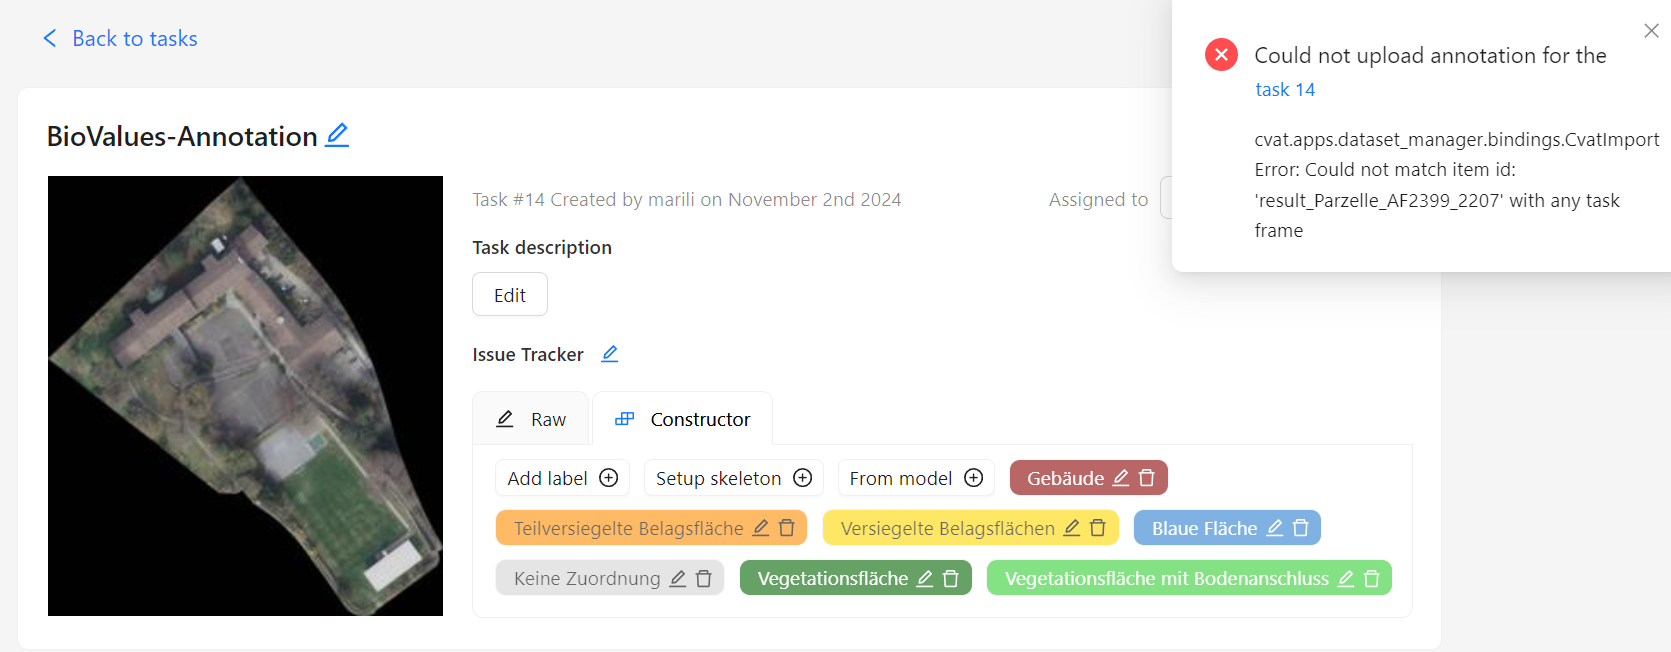

darum wird jetzt für jedes Bild ein separater TAsk erstellt und das Json individuell erstellt pro Bild und hochgeladen

aber ich lasse automatisiert jede JSON erstellen, dann muss ich nur separate Tasks erstellen, aber nicht jedes mal den Code separat anpassen

In [ ]:
import os
import json
import cv2
import numpy as np
from pycocotools import mask
from PIL import Image

# Aktualisierte BFF-Kategorien
BFF_CLASSES = [
    'Gebäude',
    'Teilversiegelte Belagsfläche',
    'Versiegelte Belagsflächen',
    'Blaue Fläche',
    'Vegetationsfläche',
    'Vegetationsfläche mit Bodenanschluss'
]

# Mapping der ursprünglichen FLAIR-Klassen zu BFF-Kategorien
FLAIR_TO_BFF_MAPPING = {
    1: 1,   # Gebäude -> Gebäude
    2: 2,   # Durchlässige Oberfläche -> Teilversiegelte Belagsfläche
    3: 3,   # Undurchlässige Oberfläche -> Versiegelte Belagsflächen
    13: 3,  # Schwimmbad -> Versiegelte Belagsflächen
    18: 1,  # Gewächshaus -> Gebäude
    4: 2,   # Unbedeckter Boden -> Teilversiegelte Belagsfläche
    5: 4,   # Wasser -> Blaue Fläche
    14: None, # Schnee -> Keine Zuordnung
    6: 5,   # Nadelbäume -> Vegetationsfläche
    7: 5,   # Laubbäume -> Vegetationsfläche
    8: 5,   # Gestrüpp -> Vegetationsfläche
    15: 6,  # Kahlschlag -> Vegetationsfläche mit Bodenanschluss
    16: 6,  # Homogene Vegetation -> Vegetationsfläche mit Bodenanschluss
    17: 6,  # Gemischte Vegetation -> Vegetationsfläche mit Bodenanschluss
    9: 6,   # Weinberge -> Vegetationsfläche mit Bodenanschluss
    11: 6,  # Landwirtschaftliche Fläche -> Vegetationsfläche mit Bodenanschluss
    12: 6,  # Gepflügtes Land -> Vegetationsfläche mit Bodenanschluss
    10: 5   # Krautige Vegetation -> Vegetationsfläche
}

def create_coco_annotations(tiff_image_path, output_json_path, image_id):
    """Konvertiert die Segmentierungsmaske in das COCO-Format mit zusammengeführten Labels."""

    # Lade das TIFF-Bild (Segmentierungsmaske)
    tiff_image = cv2.imread(tiff_image_path, cv2.IMREAD_GRAYSCALE)

    # Initialisiere die COCO JSON-Struktur
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Füge Kategorien mit BFF-Klassennamen hinzu
    for idx, class_name in enumerate(BFF_CLASSES, 1):
        category = {
            "id": idx,
            "name": class_name,
            "supercategory": "none"
        }
        coco_output['categories'].append(category)

    # Bildinformationen
    height, width = tiff_image.shape
    # Entferne das "result_" Präfix
    file_name = os.path.basename(tiff_image_path).replace("result_", "")
    image_info = {
        "id": image_id,
        "file_name": file_name,
        "height": height,
        "width": width
    }
    coco_output['images'].append(image_info)

    annotation_id = 1
    # Verarbeite die Segmentierungsmaske und mappe FLAIR-Klassen zu BFF-Klassen
    for original_class_id, bff_class_id in FLAIR_TO_BFF_MAPPING.items():
        if bff_class_id is None:
            continue  # Überspringe Klassen ohne BFF-Äquivalent

        # Erstelle eine Binärmaske für die aktuelle FLAIR-Klasse
        mask_class = (tiff_image == original_class_id).astype(np.uint8)

        # Finde Konturen für die BFF-Klasse
        contours, _ = cv2.findContours(mask_class, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) >= 3:  # Nur gültige Polygone
                segmentation = contour.flatten().tolist()
                x, y, w, h = cv2.boundingRect(contour)

                annotation = {
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": bff_class_id,
                    "segmentation": [segmentation],
                    "area": cv2.contourArea(contour),
                    "bbox": [x, y, w, h],
                    "iscrowd": 0
                }
                coco_output['annotations'].append(annotation)
                annotation_id += 1

    # Speichere die Annotationsdatei als JSON
    with open(output_json_path, 'w') as f:
        json.dump(coco_output, f, indent=4)

# Ordnerpfade
input_folder = "/content/drive/MyDrive/LabelingModel/output/"
output_folder = "/content/drive/MyDrive/LabelingModel/annotations/"

# Verarbeite jede TIFF-Datei im Eingabeordner
image_id_counter = 1
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".tif"):
        tiff_image_path = os.path.join(input_folder, filename)
        output_json_path = os.path.join(output_folder, f"annotations_coco_{filename.replace('result_', '').split('.')[0]}.json")

        # Erstelle Annotations für jede TIFF-Datei
        create_coco_annotations(tiff_image_path, output_json_path, image_id_counter)
        print(f"COCO-Annotationen für {filename} gespeichert in {output_json_path}")
        image_id_counter += 1


COCO-Annotationen für result_Parzelle_AF2399_2207.tif gespeichert in /content/drive/MyDrive/LabelingModel/annotations/annotations_coco_Parzelle_AF2399_2207.json
COCO-Annotationen für result_Parzelle_AL7430_2405.tif gespeichert in /content/drive/MyDrive/LabelingModel/annotations/annotations_coco_Parzelle_AL7430_2405.json
COCO-Annotationen für result_Parzelle_HG7626_2306.tif gespeichert in /content/drive/MyDrive/LabelingModel/annotations/annotations_coco_Parzelle_HG7626_2306.json
COCO-Annotationen für result_Parzelle_HG7909_2306.tif gespeichert in /content/drive/MyDrive/LabelingModel/annotations/annotations_coco_Parzelle_HG7909_2306.json
COCO-Annotationen für result_Parzelle_IQ6786_2407.tif gespeichert in /content/drive/MyDrive/LabelingModel/annotations/annotations_coco_Parzelle_IQ6786_2407.json
COCO-Annotationen für result_Parzelle_IQ7084_2407.tif gespeichert in /content/drive/MyDrive/LabelingModel/annotations/annotations_coco_Parzelle_IQ7084_2407.json
COCO-Annotationen für result_Parze

## Versuch 4: Segmentation Mask Format

In [ ]:
import cv2
import numpy as np
import os

# Pfade anpassen
tiff_image_path = "/content/drive/MyDrive/LabelingModel/output/result_raster_15cl.tif"
output_dir = "/content/drive/MyDrive/SegmentationClass"

# Klassenliste mit 15 Klassen (keine Background-Klasse)
classes = ['background', 'building', 'pervious_surface', 'impervious_surface', 'bare_soil',
           'water', 'coniferous', 'deciduous', 'brushwood', 'vineyard',
           'herbaceous', 'agricultural_land', 'plowed_land', 'swimming_pool', 'snow', 'greenhouse']

# Verzeichnis für Segmentierungsmasken erstellen
os.makedirs(output_dir, exist_ok=True)

# Lade das TIFF-Bild (als Graustufen)
tiff_image = cv2.imread(tiff_image_path, cv2.IMREAD_GRAYSCALE)

# Graustufenmaske erstellen und speichern
mask = np.zeros_like(tiff_image)  # Initialisiere eine Maske mit der gleichen Größe wie das Bild
for class_id, class_name in enumerate(classes):
    mask[tiff_image == class_id] = class_id

# Speichere die Maske als PNG
output_image_path = os.path.join(output_dir, 'result_raster_15cl.png')
cv2.imwrite(output_image_path, mask)

# Erstelle die default.txt in ImageSets/Segmentation
image_set_dir = "/content/drive/MyDrive/ImageSets/Segmentation"
os.makedirs(image_set_dir, exist_ok=True)
with open(os.path.join(image_set_dir, "default.txt"), "w") as f:
    f.write("result_raster_15cl")  # Bildname ohne Erweiterung


error: OpenCV(4.10.0) /io/opencv/modules/imgcodecs/src/loadsave.cpp:79: error: (-215:Assertion failed) pixels <= CV_IO_MAX_IMAGE_PIXELS in function 'validateInputImageSize'


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Lade das PNG-Bild
png_image_path = '/content/drive/MyDrive/SegmentationClass/result_raster_15cl.png'
image = cv2.imread(png_image_path)

# Konvertiere das Bild von BGR nach RGB, da OpenCV standardmäßig BGR verwendet
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Finde alle einzigartigen Farben im Bild
unique_colors = np.unique(image_rgb.reshape(-1, image_rgb.shape[2]), axis=0)

# Zeige die einzigartigen Farben an
print("Einzigartige Farben im Bild (RGB):")
print(unique_colors)

# Visualisiere die Farben
plt.figure(figsize=(10, 5))
for i, color in enumerate(unique_colors):
    plt.subplot(1, len(unique_colors), i+1)
    plt.imshow([[color]])
    plt.axis('off')

plt.show()

# Zähle die Pixel pro Farbe
pixels = image_rgb.reshape(-1, image_rgb.shape[2])
color_counts = Counter(tuple(color) for color in pixels)

print("Häufigkeit der Farben:")
for color, count in color_counts.items():
    print(f"Farbe {color} kommt {count} Mal vor.")


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


### Neuer Versuch mit Segmentation Mask

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.2 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Pfad zu deinem TIFF-Bild
tif_file_path = '/content/drive/MyDrive/LabelingModel/output/result_Parzelle_AF2399_2207.tif'

# Definiere die Farben für jede Klasse (RGB-Format)
class_colors = {
    1: (128, 0, 0),      # Gebäude
    2: (0, 128, 0),      # Unversiegelte Oberfläche
    3: (128, 128, 0),    # Versiegelte Oberfläche
    4: (128, 0, 128),    # Unbedeckter Boden
    5: (0, 0, 128),      # Wasser
    6: (0, 128, 128),    # Nadelbäume
    7: (128, 128, 128),  # Laubbäume
    8: (255, 0, 0),      # Gestrüpp
    9: (0, 255, 0),      # Weinberge
    10: (0, 0, 255),     # Krautschicht
    11: (255, 255, 0),   # Landwirtschaftliche Fläche
    12: (255, 0, 255),   # Pflügbares Land
    13: (0, 255, 255),   # Schwimmbad
    14: (192, 192, 192), # Schnee
    18: (128, 64, 0)     # Gewächshaus
}

# Lade das TIFF-Bild
with rasterio.open(tif_file_path) as src:
    prediction = src.read(1)  # Das erste Band enthält die Segmentierungsklassen

# Erstelle ein leeres RGB-Bild
rgb_image = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

# Fülle das RGB-Bild mit den Farben entsprechend den Klassen
for class_id, color in class_colors.items():
    rgb_image[prediction == class_id] = color

# Speichere das RGB-Bild als PNG
png_path = '/content/drive/MyDrive/LabelingModel/output/segmentation_mask.png'
Image.fromarray(rgb_image).save(png_path)

print(f"PNG gespeichert unter: {png_path}")


PNG gespeichert unter: /content/drive/MyDrive/LabelingModel/output/segmentation_mask.png


# Quadratmeter der Tiff-Datei erhalten

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 92.5 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np

# Load the TIFF file
tif_file_path = "/content/drive/MyDrive/LabelingModel/output/result_Parzelle_AF2399_2207.tif"

with rasterio.open(tif_file_path) as src:
    # Read the image data (first band)
    class_data = src.read(1)

    # Get the spatial resolution (area of each pixel in square meters)
    pixel_size_x, pixel_size_y = src.res
    pixel_area = pixel_size_x * pixel_size_y  # Area of each pixel

# Define your classes and initialize a dictionary to store the areas
class_labels = {
    1: 'Gebäude',
    2: 'Durchlässige Oberfläche',
    3: 'Undurchlässige Oberfläche',
    4: 'Unbedeckter Boden',
    5: 'Wasser',
    6: 'Nadelbäume',
    7: 'Laubbäume',
    8: 'Gestrüpp',
    9: 'Weinberge',
    10: 'Krautige Vegetation',
    11: 'Landwirtschaftliche Fläche',
    12: 'Gepflügtes Land',
    13: 'Schwimmbad',
    14: 'Schnee',
    18: 'Gewächshaus'
}

# Calculate the area for each class
class_areas = {}
for class_id, class_name in class_labels.items():
    pixel_count = np.sum(class_data == class_id)  # Count pixels for each class
    area = pixel_count * pixel_area  # Calculate area in square meters
    class_areas[class_name] = area

# Print the area results
for class_name, area in class_areas.items():
    print(f"{class_name}: {area:.2f} square meters")


Gebäude: 1587.75 square meters
Durchlässige Oberfläche: 3640.60 square meters
Undurchlässige Oberfläche: 18998.34 square meters
Unbedeckter Boden: 3446.20 square meters
Wasser: 71.38 square meters
Nadelbäume: 1346.94 square meters
Laubbäume: 312.65 square meters
Gestrüpp: 0.00 square meters
Weinberge: 7856.44 square meters
Krautige Vegetation: 870.39 square meters
Landwirtschaftliche Fläche: 18.34 square meters
Gepflügtes Land: 0.00 square meters
Schwimmbad: 0.00 square meters
Schnee: 0.00 square meters
Gewächshaus: 0.00 square meters


In [ ]:
import rasterio
import numpy as np

# Load the TIFF file
tif_file_path = "/content/drive/MyDrive/LabelingModel/output/result_Parzelle_AF2399_2207.tif"

with rasterio.open(tif_file_path) as src:
    # Read the image data (first band)
    class_data = src.read(1)

    # Get the spatial resolution (area of each pixel in square meters)
    pixel_size_x, pixel_size_y = src.res
    pixel_area = pixel_size_x * pixel_size_y  # Area of each pixel

# Define the new labels and initialize a dictionary to store the areas
class_labels = {
    1: 'Gebäude',
    2: 'Teilversiegelte Belagsfläche',        # Durchlässige Oberfläche
    3: 'Versiegelte Belagsfläche',            # Undurchlässige Oberfläche
    4: 'Teilversiegelte Belagsfläche',        # Unbedeckter Boden
    5: 'Blaue Fläche',                        # Wasser
    6: 'Vegetationsfläche',                   # Nadelbäume
    7: 'Vegetationsfläche',                   # Laubbäume
    8: 'Vegetationsfläche',                   # Gestrüpp
    9: 'Vegetationsfläche mit Bodenanschluss',# Weinberge
    10: 'Vegetationsfläche',                  # Krautige Vegetation
    11: 'Vegetationsfläche mit Bodenanschluss', # Landwirtschaftliche Fläche
    12: 'Vegetationsfläche mit Bodenanschluss', # Gepflügtes Land
    13: 'Versiegelte Belagsfläche',           # Schwimmbad
    14: 'Keine Zuordnung',                    # Schnee
    15: 'Vegetationsfläche mit Bodenanschluss', # Kahlschlag
    16: 'Vegetationsfläche mit Bodenanschluss', # Homogene Vegetation
    17: 'Vegetationsfläche mit Bodenanschluss', # Gemischte Vegetation
    18: 'Gebäude'                             # Gewächshaus
}

# Calculate the area for each class
class_areas = {}
for class_id, class_name in class_labels.items():
    pixel_count = np.sum(class_data == class_id)  # Count pixels for each class
    area = pixel_count * pixel_area  # Calculate area in square meters

    # Accumulate areas for labels that map to the same class (e.g., Vegetationsfläche)
    if class_name in class_areas:
        class_areas[class_name] += area
    else:
        class_areas[class_name] = area

# Print the area results
for class_name, area in class_areas.items():
    print(f"{class_name}: {area:.2f} square meters")


Gebäude: 1587.75 square meters
Teilversiegelte Belagsfläche: 7086.80 square meters
Versiegelte Belagsfläche: 18998.34 square meters
Blaue Fläche: 71.38 square meters
Vegetationsfläche: 2529.97 square meters
Vegetationsfläche mit Bodenanschluss: 8085.48 square meters
Keine Zuordnung: 0.00 square meters


In [ ]:
import rasterio
import numpy as np

# Load the TIFF file
tif_file_path = "/content/drive/MyDrive/LabelingModel/output/result_Parzelle_AF2399_2207.tif"

with rasterio.open(tif_file_path) as src:
    # Read the image data (first band)
    class_data = src.read(1)

    # Get the spatial resolution (area of each pixel in square meters)
    pixel_size_x, pixel_size_y = src.res
    pixel_area = pixel_size_x * pixel_size_y  # Area of each pixel

# Define the new labels and initialize a dictionary to store the areas
class_labels = {
    1: 'Gebäude',
    2: 'Teilversiegelte Belagsfläche',        # Durchlässige Oberfläche
    3: 'Versiegelte Belagsfläche',            # Undurchlässige Oberfläche
    4: 'Teilversiegelte Belagsfläche',        # Unbedeckter Boden
    5: 'Blaue Fläche',                        # Wasser
    6: 'Vegetationsfläche',                   # Nadelbäume
    7: 'Vegetationsfläche',                   # Laubbäume
    8: 'Vegetationsfläche',                   # Gestrüpp
    9: 'Vegetationsfläche mit Bodenanschluss',# Weinberge
    10: 'Vegetationsfläche',                  # Krautige Vegetation
    11: 'Vegetationsfläche mit Bodenanschluss', # Landwirtschaftliche Fläche
    12: 'Vegetationsfläche mit Bodenanschluss', # Gepflügtes Land
    13: 'Versiegelte Belagsfläche',           # Schwimmbad
    14: 'Keine Zuordnung',                    # Schnee
    15: 'Vegetationsfläche mit Bodenanschluss', # Kahlschlag
    16: 'Vegetationsfläche mit Bodenanschluss', # Homogene Vegetation
    17: 'Vegetationsfläche mit Bodenanschluss', # Gemischte Vegetation
    18: 'Gebäude'                             # Gewächshaus
}

# Calculate the area for each class
class_areas = {}
total_pixel_count = 0

for class_id, class_name in class_labels.items():
    pixel_count = np.sum(class_data == class_id)  # Count pixels for each class
    area = pixel_count * pixel_area  # Calculate area in square meters
    total_pixel_count += pixel_count  # Sum up total pixels for the property

    # Accumulate areas for labels that map to the same class (e.g., Vegetationsfläche)
    if class_name in class_areas:
        class_areas[class_name] += area
    else:
        class_areas[class_name] = area

# Calculate total area of the property
total_area = total_pixel_count * pixel_area

# Print the area results
print(f"Total area of the property: {total_area:.2f} square meters\n")
print("Area per category:")
for class_name, area in class_areas.items():
    print(f"{class_name}: {area:.2f} square meters")


Total area of the property: 38359.73 square meters

Area per category:
Gebäude: 1587.75 square meters
Teilversiegelte Belagsfläche: 7086.80 square meters
Versiegelte Belagsfläche: 18998.34 square meters
Blaue Fläche: 71.38 square meters
Vegetationsfläche: 2529.97 square meters
Vegetationsfläche mit Bodenanschluss: 8085.48 square meters
Keine Zuordnung: 0.00 square meters


In [ ]:
# Define paths
input_folder = "/content/drive/MyDrive/LabelingModel/output/"
output_folder = "/content/drive/MyDrive/LabelingModel/annotations/"

In [ ]:
import pandas as pd
import rasterio

# Define the mapping of class IDs and names
class_labels = {
    1: 'Gebäude',
    2: 'Teilversiegelte Belagsfläche',
    3: 'Versiegelte Belagsfläche',
    4: 'Teilversiegelte Belagsfläche',
    5: 'Blaue Fläche',
    6: 'Vegetationsfläche',
    7: 'Vegetationsfläche',
    8: 'Vegetationsfläche',
    9: 'Vegetationsfläche mit Bodenanschluss',
    10: 'Vegetationsfläche',
    11: 'Vegetationsfläche mit Bodenanschluss',
    12: 'Vegetationsfläche mit Bodenanschluss',
    13: 'Versiegelte Belagsfläche',
    14: 'Keine Zuordnung',
    18: 'Gebäude'
}

# Initialize dataframe to store area results
results = []

# Calculate area for each TIFF file
for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        tiff_image_path = os.path.join(input_folder, filename)

        with rasterio.open(tiff_image_path) as src:
            class_data = src.read(1)
            pixel_size_x, pixel_size_y = src.res
            pixel_area = pixel_size_x * pixel_size_y  # m²

        class_areas = {}
        total_pixel_count = np.count_nonzero(class_data)

        for class_id, class_name in class_labels.items():
            pixel_count = np.sum(class_data == class_id)
            area = pixel_count * pixel_area

            if class_name in class_areas:
                class_areas[class_name] += area
            else:
                class_areas[class_name] = area

        total_area = total_pixel_count * pixel_area
        row = {"File": filename, "Total Area (m²)": total_area}
        row.update(class_areas)
        results.append(row)

# Create a DataFrame and display
df_results = pd.DataFrame(results).fillna(0)
print(df_results)


                               File  Total Area (m²)     Gebäude  \
0                 result_raster.tif     3.835973e+04   1587.7525   
1   result_Parzelle_SE6637_2107.tif     4.359875e+03   1211.5100   
2   result_Parzelle_HG7626_2306.tif     7.812210e+03    366.0300   
3   result_Parzelle_OB2939_2408.tif     4.084950e+02      1.3100   
4   result_Parzelle_RI5416_2608.tif     3.957401e+04   7955.3000   
5   result_Parzelle_RI5481_2609.tif     1.873505e+04   6617.5475   
6   result_Parzelle_OB3455_2308.tif     1.294788e+03      4.9925   
7   result_Parzelle_AL7430_2405.tif     1.098210e+03      0.0000   
8   result_Parzelle_WO1900_2707.tif     2.712625e+02      4.2550   
9   result_Parzelle_AF2399_2207.tif     3.835973e+04   1587.7525   
10  result_Parzelle_WI3878_2609.tif     1.147791e+04    283.4150   
11  result_Parzelle_IQ6786_2407.tif     1.724563e+04    157.0775   
12  result_Parzelle_HG7909_2306.tif     1.555475e+03      6.1800   
13  result_Parzelle_IQ7084_2407.tif     2.448640

# Versuch Model direkt in CVAT local zu importieren

## YAML File für Docker vorbereiten, um FLAIR Model im CVAT direkt zu öffnen

In [ ]:
yaml_content = """
output_path: /app/output  # Temporärer Speicherort, kann entfernt oder angepasst werden
output_name: result_raster_15cl

input_img_path: /app/input/Parzelle_AF2399_2207.tif
channels: [1, 2, 3, 4]  # RGB + Nahes Infrarot (NIR)

img_pixels_detection: 512
margin: 128
output_type: "argmax"  # Dies kann angepasst werden, je nach gewünschtem Format
n_classes: 19

model_weights: /app/model_weights.pth
model_framework:
    model_provider: SegmentationModelsPytorch
    HuggingFace:
        org_model: IGNF/FLAIR-INC_rgbi_15cl_resnet34-unet
    SegmentationModelsPytorch:
        encoder_decoder: resnet34_unet

batch_size: 4
use_gpu: true
model_name: 'unet'
encoder_name: 'resnet34'
num_worker: 2

write_dataframe: false  # Da keine Speicherung als CSV oder ähnliches gewünscht ist

norma_task:
  - norm_type: custom
    norm_means: [105.08, 110.87, 101.82, 106.38]
    norm_stds: [52.17, 45.38, 44.0, 39.69]
"""


# Speichere das YAML-File
with open("/content/drive/MyDrive/LabelingModel/flair-1-config-detect-docker.yaml", "w") as file:
    file.write(yaml_content)

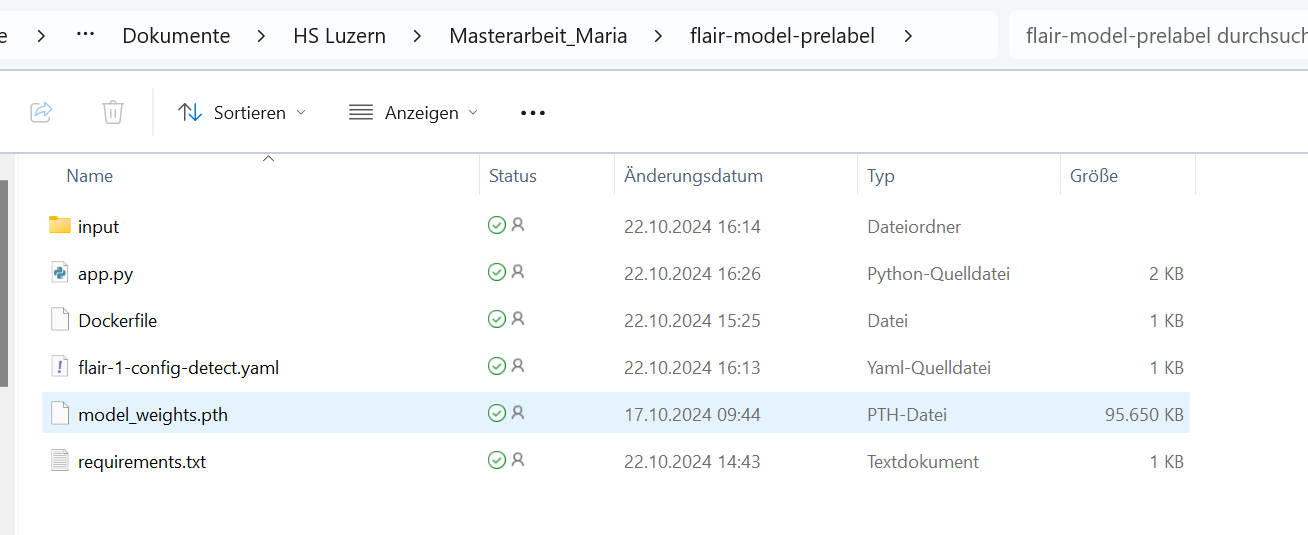

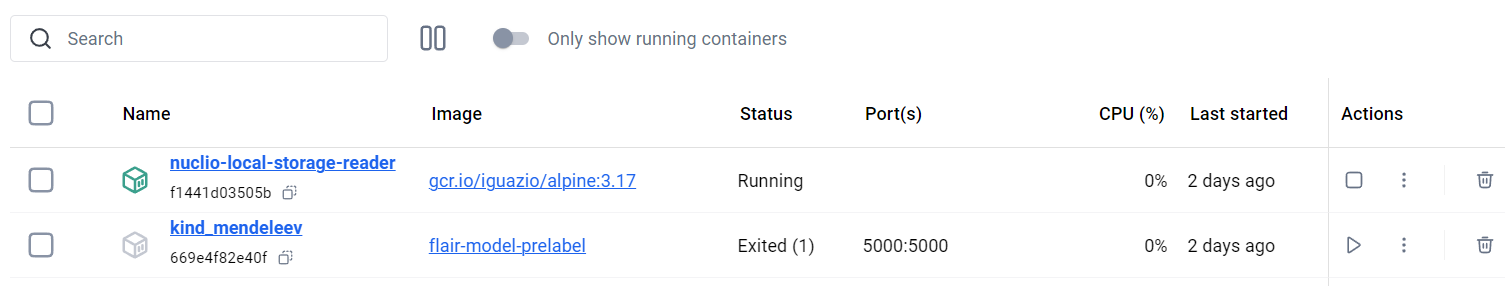

hat nicht geklappt, wieder wg Nuclio gescheitert..